## Stylometry detection

In [1]:
!pip install odfpy
import pandas as pd

prmnt_sample= pd.read_excel("prominent-sample-users.ods", engine="odf")
display(prmnt_sample)

You should consider upgrading via the 'c:\users\monique\anaconda3\python.exe -m pip install --upgrade pip' command.


,Author,Gender_label,Gender_binary,User_name,Succession
0,Jeff Bezos,male,0,JeffBezos,"American entrepreneur, media proprietor, inves..."
1,Elon Musk,male,0,elonmusk,South African entrepreneur and business magnat...
2,Bill Gates,male,0,BillGates,"American business magnate, software developer,..."
3,Tim Cook,male,0,tim_cook,American business executive who has been the c...
4,John Flannery,male,0,JohnFlannery_GE,American business executive. He succeeded Jeff...
...,...,...,...,...,...
235,Priti Patel,female,1,pritipatel,British politician who has been serving as Hom...
236,Liz Truss,female,1,trussliz,British politician serving as Foreign Secretar...
237,Suella Braverman,female,1,SuellaBraverman,British politician. She was appointed Attorney...
238,Ann Curry,female,1,AnnCurry,"American journalist and photojournalist, Co-an..."


### Data pre-processing

In [15]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

import pandas as pd
stylometry = pd.read_csv('prominent-sample.csv')

# rename the columns
stylometry = stylometry.set_axis(['User_name', 'Date', 'Tweet_ID', 'Text'], axis=1, inplace=False)

# delete columns with dates and tweet id 
stylometry = stylometry.drop('Date', 1)
stylometry = stylometry.drop('Tweet_ID', 1)

# remove retweets
stylometry = stylometry[~stylometry.Text.str.startswith('RT')]

# exclude users with less than 2000 original tweets
stylometry = stylometry.groupby('User_name').filter(lambda x : len(x)>2000)

# keep 2000 tweets for every user
stylometry = stylometry.groupby('User_name').head(2000).reset_index(drop=True)

# concatenate bundles of 100 chronological tweets 
stylometry_text = stylometry.groupby(np.arange(len(stylometry.index))//100, axis=0).agg({'Text': list})
stylometry_text['User_name_chrono'] = np.nan
stylometry_text['User_name'] = np.nan

unique_user = []
for user in stylometry['User_name']:
    if user not in unique_user:
        unique_user.append(user)
    
index = 0
for user in unique_user:
    for i in range(20, 0, -1):
        user_chrono = user + str(i)
        stylometry_text['User_name'][index] = user
        stylometry_text['User_name_chrono'][index] = user_chrono
        index += 1

# attach binary gender label to dataframe (i.e. concatinate original and scraped dataframe)
stylometry_text = stylometry_text.merge(prmnt_sample, on='User_name', how='left')

stylometry_text = stylometry_text.drop_duplicates(subset='User_name_chrono', keep='first', inplace=False)
stylometry_text = stylometry_text.drop('Author', 1)

# reset the index
stylometry_text.reset_index(inplace=True)
stylometry_text = stylometry_text.drop(['index'], axis=1)

# lowercasing
for index in range(0, len(stylometry_text)):
    stylometry_text['Text'][index] = ''.join(stylometry_text['Text'][index]).lower()
    
# replace all URLs with 'URL'
import re
for index in range(0, len(stylometry_text)):
    stylometry_text['Text'][index] = re.sub(r'http\S+', 'URL', ''.join(stylometry_text['Text'][index]))

# replace all usernames with 'USER'
for index in range(0, len(stylometry_text)):
    stylometry_text['Text'][index] = re.sub(r'\B@\w+', 'USER', ''.join(stylometry_text['Text'][index]))

# create an additional tokenized text column (word tokenization)
import numpy as np
from nltk.tokenize import word_tokenize

stylometry_text['tokenized_text'] = np.nan
for index in range(0, len(stylometry_text)):
    stylometry_text['tokenized_text'][index] = word_tokenize(stylometry_text['Text'][index])

display(stylometry_text)  

,Text,User_name_chrono,User_name,Gender_label,Gender_binary,Succession,tokenized_text
0,"by investing in direct air capture, clean hydr...",BillGates20,BillGates,male,0,"American business magnate, software developer,...","[by, investing, in, direct, air, capture, ,, c..."
1,the journalist USER has created a fascinating ...,BillGates19,BillGates,male,0,"American business magnate, software developer,...","[the, journalist, USER, has, created, a, fasci..."
2,rashida jones and i talked to yuval noah harar...,BillGates18,BillGates,male,0,"American business magnate, software developer,...","[rashida, jones, and, i, talked, to, yuval, no..."
3,there’s been some progress on more efficient t...,BillGates17,BillGates,male,0,"American business magnate, software developer,...","[there, ’, s, been, some, progress, on, more, ..."
4,malnutrition is the single greatest health ine...,BillGates16,BillGates,male,0,"American business magnate, software developer,...","[malnutrition, is, the, single, greatest, heal..."
...,...,...,...,...,...,...,...
2095,felony murder is murder. it is murder that occ...,greta 5,greta,female,1,"American commentator, lawyer, and former telev...","[felony, murder, is, murder, ., it, is, murder..."
2096,is this what nick is going to look like when h...,greta 4,greta,female,1,"American commentator, lawyer, and former telev...","[is, this, what, nick, is, going, to, look, li..."
2097,really? who didn’t know this was coming (see b...,greta 3,greta,female,1,"American commentator, lawyer, and former telev...","[really, ?, who, didn, ’, t, know, this, was, ..."
2098,"ok, i listened to it..listening to the whole t...",greta 2,greta,female,1,"American commentator, lawyer, and former telev...","[ok, ,, i, listened, to, it..listening, to, th..."


### Feature extraction

In [16]:
# number of words
stylometry_text['n_words'] = stylometry_text['tokenized_text'].str.len()

# number of characters
stylometry_text['n_char'] = stylometry_text['Text'].str.len()

# average lenght of words (n_char divided by n_words)
stylometry_text['avg_len'] = stylometry_text['n_char']/stylometry_text['n_words']

# average number of words per tweet
stylometry_text['avg_tweet_len'] = stylometry_text['n_words']/100

# vocabulary diversity (number of tokens divided by number of types) higher is more divers
stylometry_text['divers'] = np.nan
for index in range(0, len(stylometry_text)):
    stylometry_text['divers'][index] = len(set(stylometry_text['tokenized_text'][index])) / stylometry_text['n_words'][index]

# overall polarity
from textblob import TextBlob
stylometry_text['polarity'] = np.nan

for index in range(0, len(stylometry_text)):
    text_blob = TextBlob(stylometry_text['Text'][index])
    stylometry_text['polarity'][index] = text_blob.sentiment.polarity
    
# overall subjectivity
stylometry_text['subjectivity'] = np.nan

for index in range(0, len(stylometry_text)):
    text_blob = TextBlob(stylometry_text['Text'][index])
    stylometry_text['subjectivity'][index] = text_blob.sentiment.subjectivity

# PoS-tagging 
import nltk
stylometry_text['PoS'] = np.nan

for index in range(0, len(stylometry_text)):
    stylometry_text['PoS'][index] = nltk.pos_tag(stylometry_text['tokenized_text'][index])

display(stylometry_text)

,Text,User_name_chrono,User_name,Gender_label,Gender_binary,Succession,tokenized_text,n_words,n_char,avg_len,avg_tweet_len,divers,polarity,subjectivity,PoS
0,"by investing in direct air capture, clean hydr...",BillGates20,BillGates,male,0,"American business magnate, software developer,...","[by, investing, in, direct, air, capture, ,, c...",2125,11105,5.225882,21.25,0.375059,0.255997,0.537138,"[(by, IN), (investing, VBG), (in, IN), (direct..."
1,the journalist USER has created a fascinating ...,BillGates19,BillGates,male,0,"American business magnate, software developer,...","[the, journalist, USER, has, created, a, fasci...",2028,10367,5.111933,20.28,0.343195,0.247537,0.480010,"[(the, DT), (journalist, NN), (USER, NNP), (ha..."
2,rashida jones and i talked to yuval noah harar...,BillGates18,BillGates,male,0,"American business magnate, software developer,...","[rashida, jones, and, i, talked, to, yuval, no...",2127,11144,5.239304,21.27,0.374236,0.218527,0.518321,"[(rashida, NN), (jones, NNS), (and, CC), (i, N..."
3,there’s been some progress on more efficient t...,BillGates17,BillGates,male,0,"American business magnate, software developer,...","[there, ’, s, been, some, progress, on, more, ...",2146,10891,5.075023,21.46,0.358341,0.287893,0.516219,"[(there, RB), (’, JJ), (s, NN), (been, VBN), (..."
4,malnutrition is the single greatest health ine...,BillGates16,BillGates,male,0,"American business magnate, software developer,...","[malnutrition, is, the, single, greatest, heal...",2237,11102,4.962897,22.37,0.336612,0.243798,0.542353,"[(malnutrition, NN), (is, VBZ), (the, DT), (si..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,felony murder is murder. it is murder that occ...,greta 5,greta,female,1,"American commentator, lawyer, and former telev...","[felony, murder, is, murder, ., it, is, murder...",1786,8894,4.979843,17.86,0.376260,0.155205,0.558594,"[(felony, NN), (murder, NN), (is, VBZ), (murde..."
2096,is this what nick is going to look like when h...,greta 4,greta,female,1,"American commentator, lawyer, and former telev...","[is, this, what, nick, is, going, to, look, li...",1716,8567,4.992424,17.16,0.359557,0.009001,0.440144,"[(is, VBZ), (this, DT), (what, WP), (nick, NN)..."
2097,really? who didn’t know this was coming (see b...,greta 3,greta,female,1,"American commentator, lawyer, and former telev...","[really, ?, who, didn, ’, t, know, this, was, ...",1635,8122,4.967584,16.35,0.426300,0.203385,0.506400,"[(really, RB), (?, .), (who, WP), (didn, VBP),..."
2098,"ok, i listened to it..listening to the whole t...",greta 2,greta,female,1,"American commentator, lawyer, and former telev...","[ok, ,, i, listened, to, it..listening, to, th...",1874,9300,4.962647,18.74,0.392209,0.151252,0.536324,"[(ok, NN), (,, ,), (i, NN), (listened, VBD), (..."


In [17]:
# word uni-grams
uni_gram = pd.read_csv('word_uni_grams.csv')
uni_gram = uni_gram['0'].tolist()

for word in uni_gram:
    stylometry_text[word] = 0 

for index in range(0, len(stylometry_text)):
    for word in stylometry_text['tokenized_text'][index]:
        if word in uni_gram:
            stylometry_text[word][index] += 1

In [18]:
# character tri-grams
tri_gram = pd.read_csv('character_tri_grams.csv')
tri_gram = tri_gram['0'].tolist()

for ngram in tri_gram:
    stylometry_text[ngram] = 0 

for index in range(0, len(stylometry_text)): 
    tri_gram_index = [stylometry_text['Text'][index][i:i+3] for i in range(len(stylometry_text['Text'][index])-1)]
    
    for ngram in tri_gram_index:
        if ngram in tri_gram:
            stylometry_text[ngram][index] += 1 

In [19]:
# get the raw frequency of PoS tags
from collections import Counter
pos_total = pd.read_csv('pos_total_set.csv')
pos_total = pos_total['0'].tolist()

for pos in pos_total[:15]:
    stylometry_text[pos] = 0
    
for index in range(0, len(stylometry_text)):
    pos_row = Counter([j for i,j in stylometry_text['PoS'][index]])
    
    stylometry_text['NN'][index] = pos_row.get('NN') 
    stylometry_text['JJ'][index] = pos_row.get('JJ')
    stylometry_text['NNP'][index] = pos_row.get('NNP')
    stylometry_text['IN'][index] = pos_row.get('IN')
    stylometry_text['DT'][index] = pos_row.get('DT')
    stylometry_text['RB'][index] = pos_row.get('RB')
    stylometry_text['.'][index] = pos_row.get('.')
    stylometry_text['VB'][index] = pos_row.get('VB')
    stylometry_text['NNS'][index] = pos_row.get('NNS')
    stylometry_text['PRP'][index] = pos_row.get('PRP')
    stylometry_text['VBP'][index] = pos_row.get('VBP')
    stylometry_text['VBZ'][index] = pos_row.get('VBZ')
    stylometry_text['VBD'][index] = pos_row.get('VBD')
    stylometry_text['CC'][index] = pos_row.get('CC')
    stylometry_text['TO'][index] = pos_row.get('TO')
    
stylometry_text['NN'] =  stylometry_text['NN'] / stylometry_text['n_words']
stylometry_text['JJ'] =  stylometry_text['JJ'] / stylometry_text['n_words']
stylometry_text['NNP'] =  stylometry_text['NNP'] / stylometry_text['n_words']
stylometry_text['IN'] =  stylometry_text['IN'] / stylometry_text['n_words']
stylometry_text['DT'] =  stylometry_text['DT'] / stylometry_text['n_words']
stylometry_text['RB'] =  stylometry_text['RB'] / stylometry_text['n_words']
stylometry_text['.'] =  stylometry_text['.'] / stylometry_text['n_words']
stylometry_text['VB'] =  stylometry_text['VB'] / stylometry_text['n_words']
stylometry_text['NNS'] =  stylometry_text['NNS'] / stylometry_text['n_words']
stylometry_text['PRP'] =  stylometry_text['PRP'] / stylometry_text['n_words']
stylometry_text['VBP'] =  stylometry_text['VBP'] / stylometry_text['n_words']
stylometry_text['VBZ'] =  stylometry_text['VBZ'] / stylometry_text['n_words']
stylometry_text['VBD'] =  stylometry_text['VBD'] / stylometry_text['n_words']
stylometry_text['CC'] =  stylometry_text['CC'] / stylometry_text['n_words']
stylometry_text['TO'] =  stylometry_text['TO'] / stylometry_text['n_words']

### Apply best model to clustered tweets

In [21]:
stylometry_text = stylometry_text.drop('PoS', 1)
x_prominent = stylometry_text.iloc[:, 7:len(stylometry_text.columns)]
x_prominent = x_prominent.fillna(0)
y_prominent = stylometry_text['Gender_binary']

In [22]:
x_train = pd.read_csv('x_train.csv')
x_train = x_train.drop('nan', 1)
y_train = pd.read_csv('y_train.csv')

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

RF = RandomForestClassifier(criterion = 'gini',
                                        n_estimators = 160,
                                        max_features = 1000,
                                        max_depth = 60,
                                        random_state = 0)
RF.fit(x_train, y_train)
y_pred = RF.predict(x_prominent)

print(accuracy_score(y_prominent, y_pred))
print(confusion_matrix(y_prominent, y_pred))
print(classification_report(y_prominent, y_pred))

0.5771428571428572
[[1043   37]
 [ 851  169]]
              precision    recall  f1-score   support

           0       0.55      0.97      0.70      1080
           1       0.82      0.17      0.28      1020

    accuracy                           0.58      2100
   macro avg       0.69      0.57      0.49      2100
weighted avg       0.68      0.58      0.49      2100



In [24]:
# appending the probability for the male class to the dataframe
class_prob = RF.predict_proba(x_prominent) 
stylometry_text['male_prob'] = class_prob[:,:1]
stylometry_text['female_prob'] = class_prob[:,1:2]

### Visualizations

BillGates


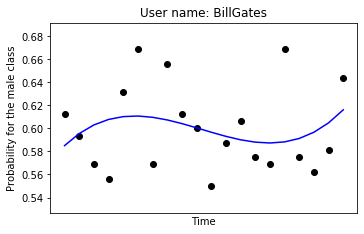

antonioguterres


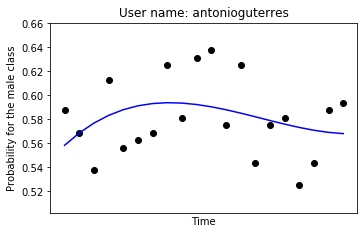

MikeBloomberg


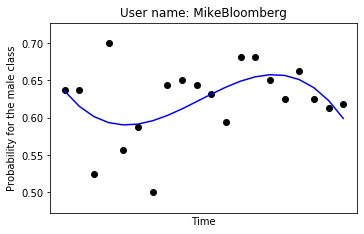

JustinTrudeau


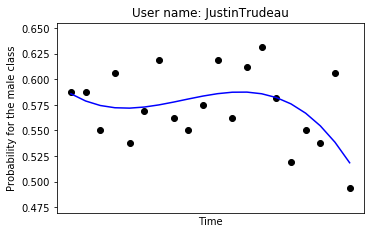

MichaelDell


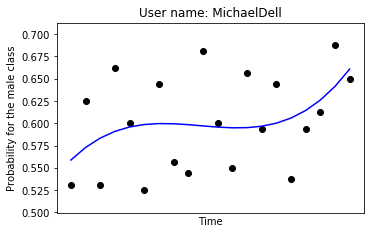

JoeBiden


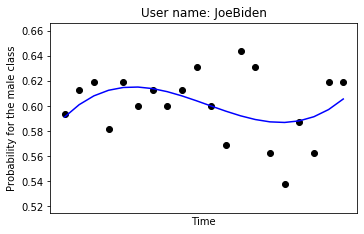

BarackObama


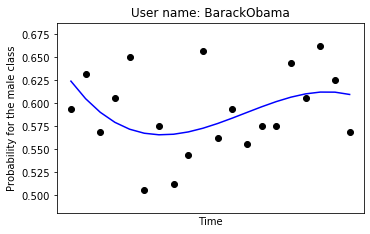

richardbranson


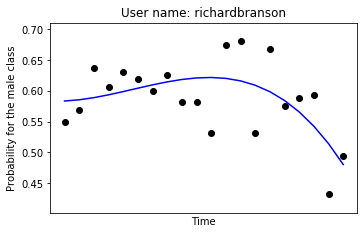

LeaderMcConnell


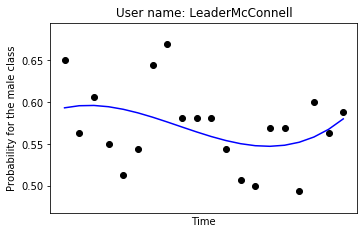

marcorubio


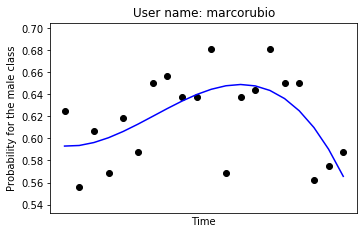

BetoORourke


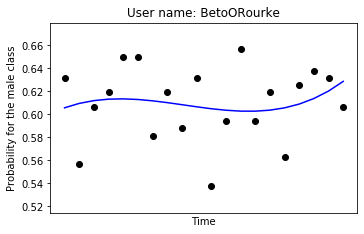

Schwarzenegger


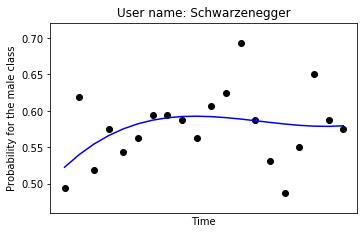

Nigel_Farage


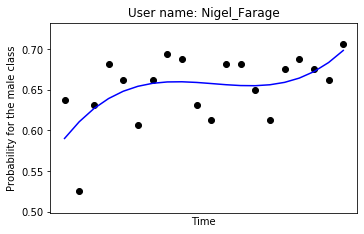

travisk


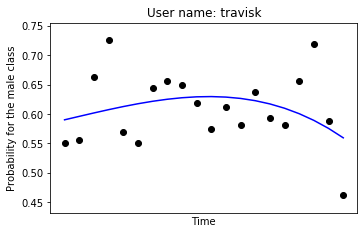

mcuban


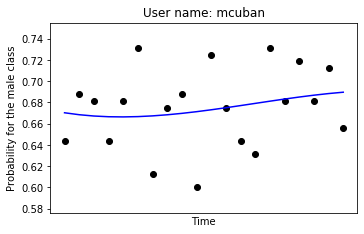

ThisIsSethsBlog


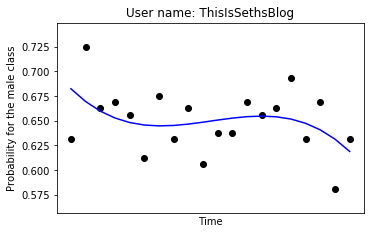

GuyKawasaki


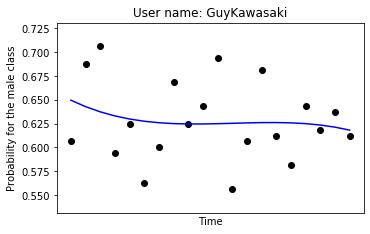

garyvee


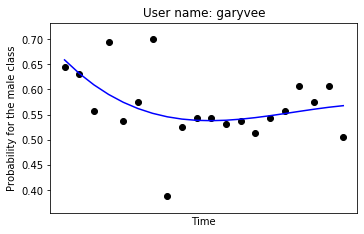

ev


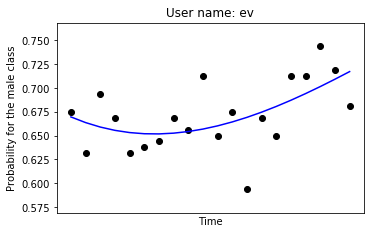

biz


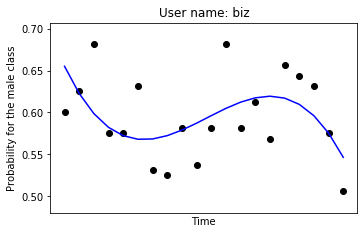

BernieSanders


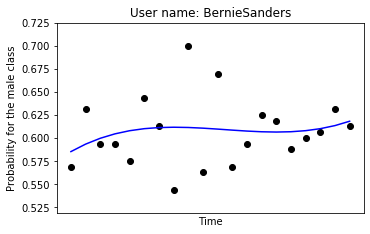

IamSteveHarvey


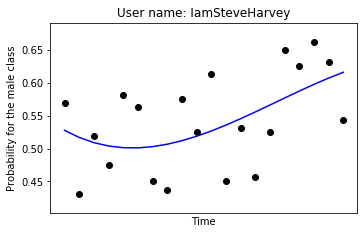

BillNye


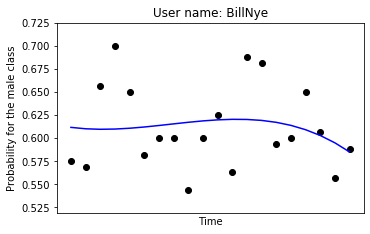

StephenAtHome


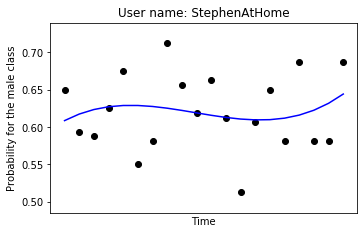

jimmyfallon


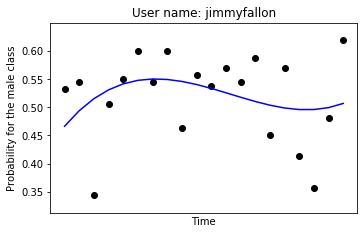

BorisJohnson


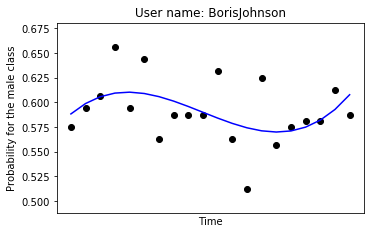

jeremycorbyn


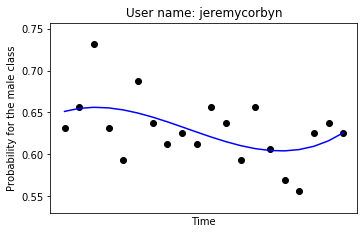

jimmykimmel


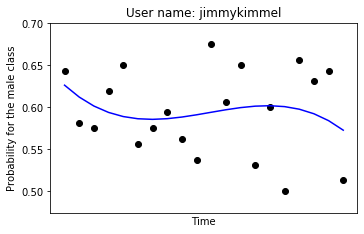

DrPhil


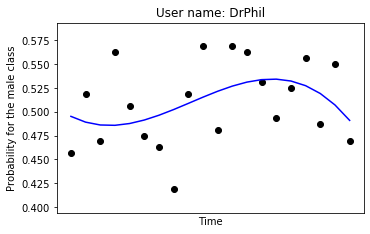

DavidMuir


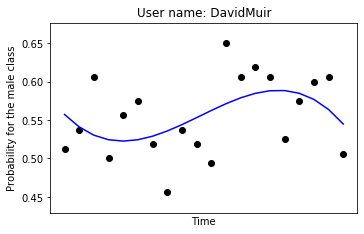

ConanOBrien


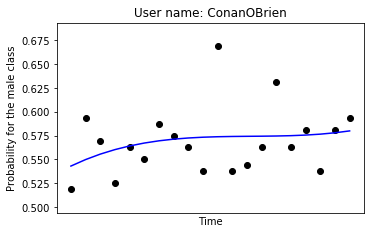

SenMarkey


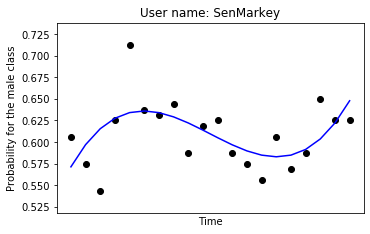

DickDurbin


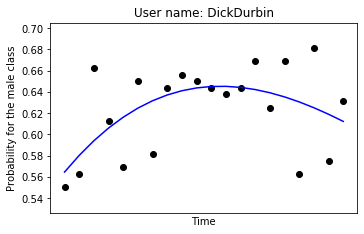

sethmeyers


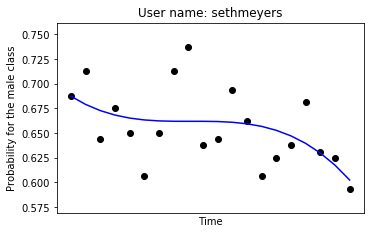

ChrisMurphyCT


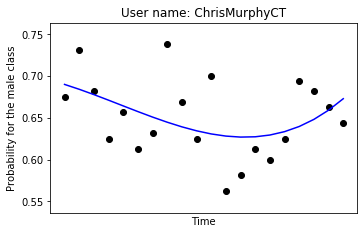

CoryBooker


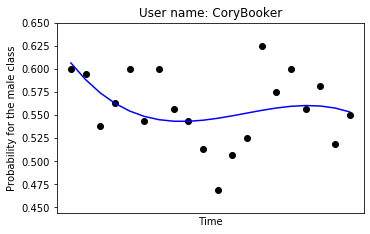

SenSchumer


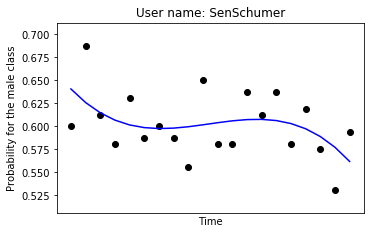

tom_watson


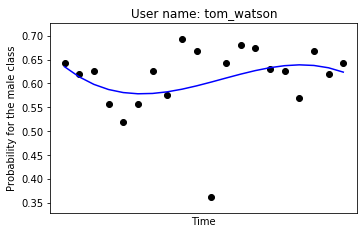

OwenJones84


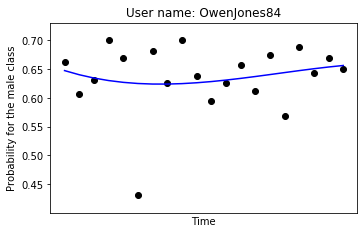

timfarron


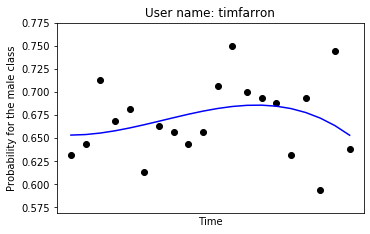

AlexSalmond


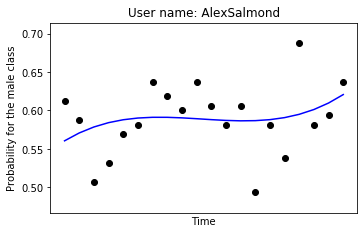

CapehartJ


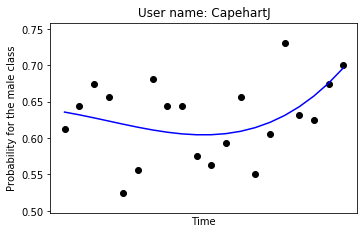

RBReich


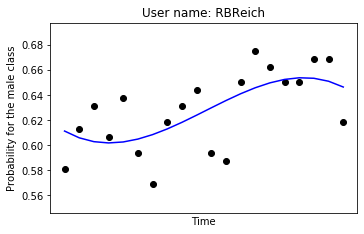

dougducey


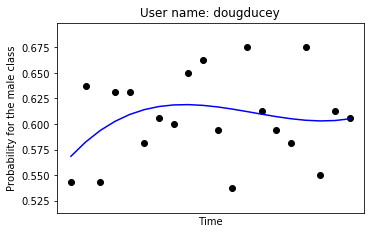

devinwenig


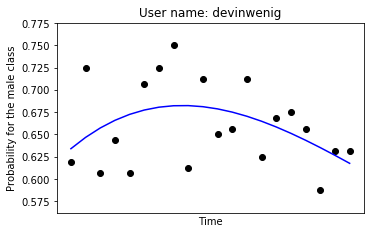

TheSharkDaymond


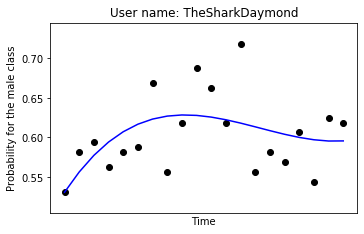

Pgelsinger


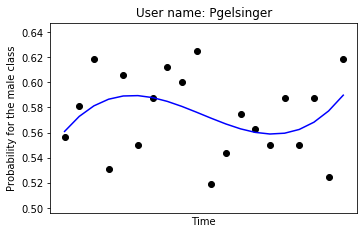

PhiwaNk


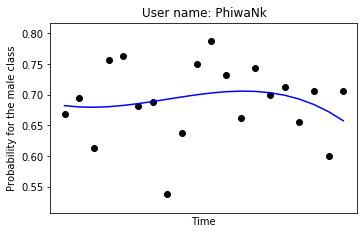

JeremyClarkson


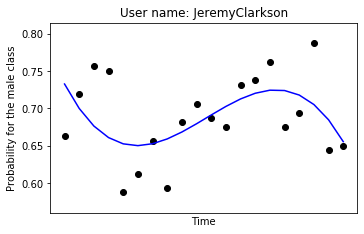

Rich_Barton


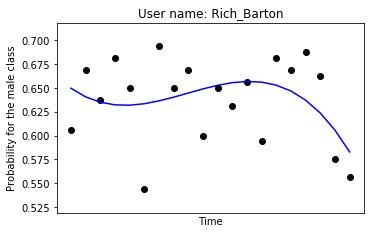

TEDchris


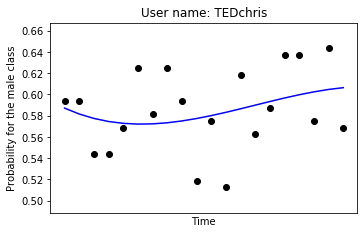

KenRoth


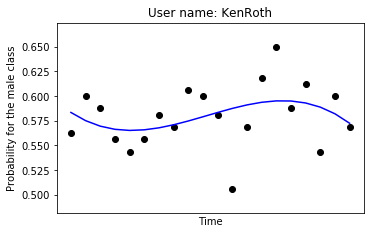

Trevornoah


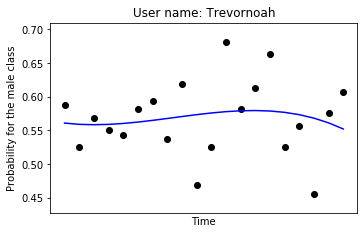

louistheroux


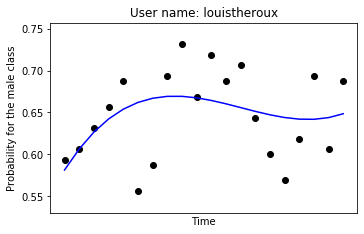

Lagarde


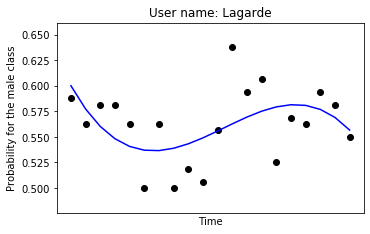

KamalaHarris


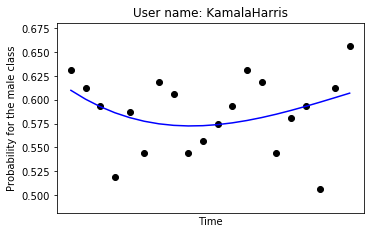

vonderleyen


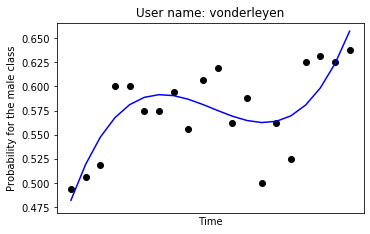

melindagates


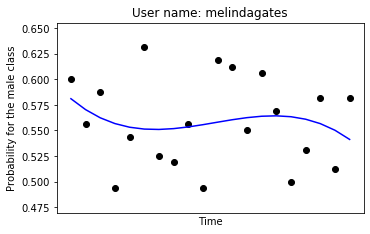

SpeakerPelosi


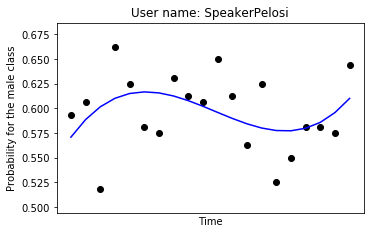

Kgeorgieva


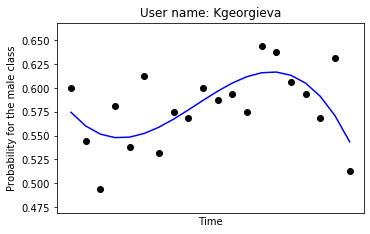

Oprah


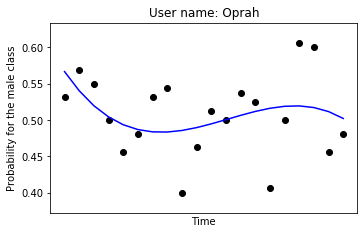

jacindaardern


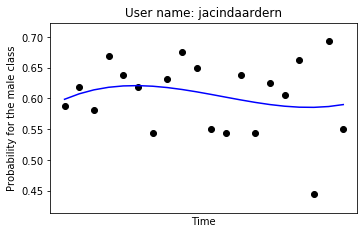

toryburch


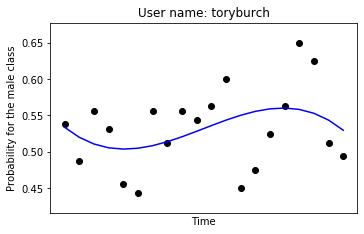

ReeseW


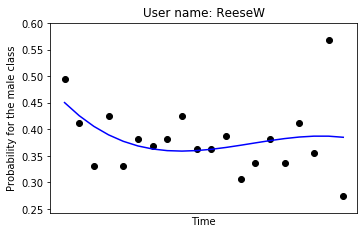

aileenlee


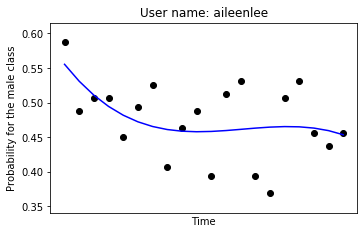

HillaryClinton


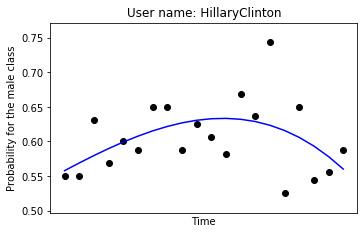

mariashriver


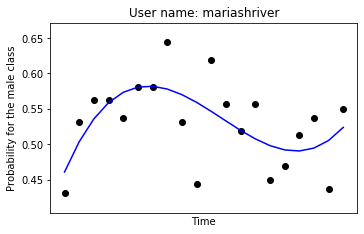

TheEllenShow


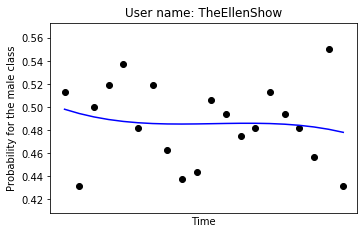

SenWarren


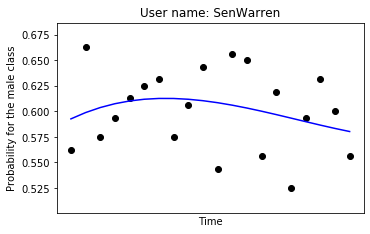

mariaressa


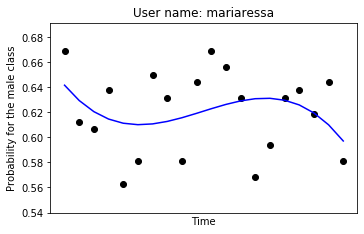

vestager


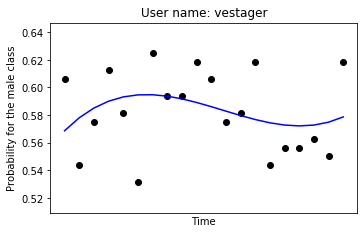

rosemcgowan


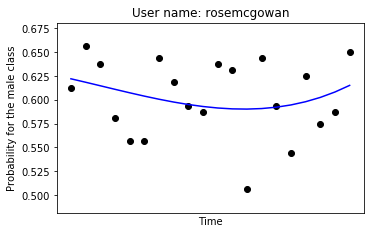

moiraforbes


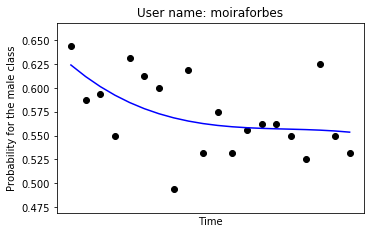

sophiaamoruso


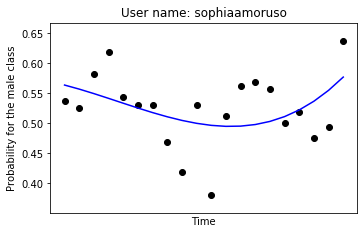

MarthaStewart


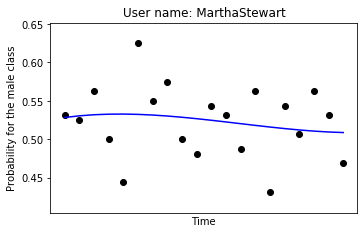

GretchenCarlson


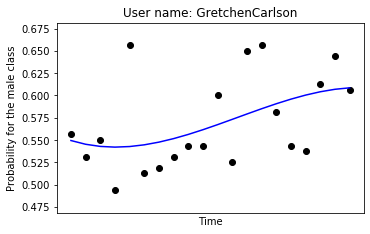

thepioneerwoman


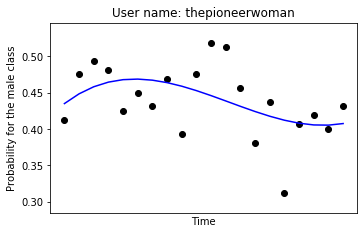

amyklobuchar


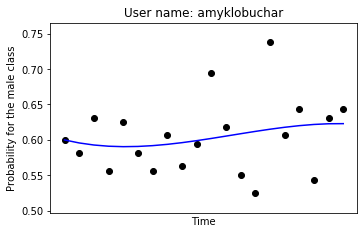

bethcomstock


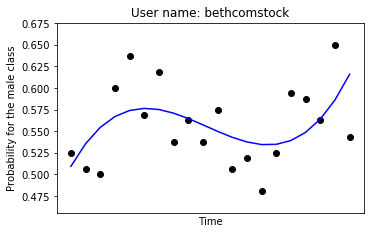

cindi_leive


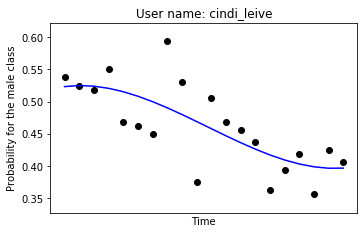

CarlyFiorina


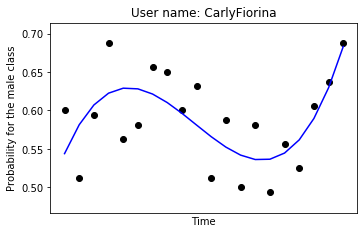

BreneBrown


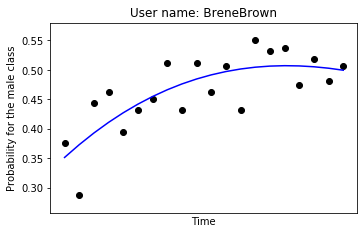

JeanChatzky


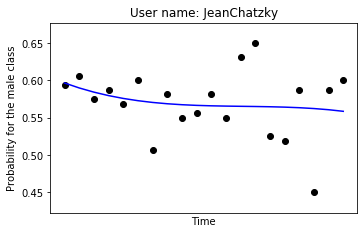

emmaladyrose


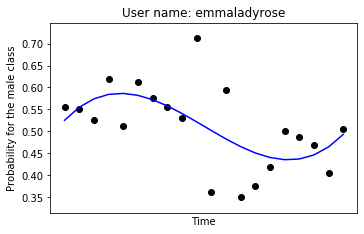

clairecm


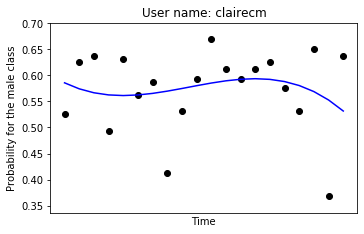

SarahKSilverman


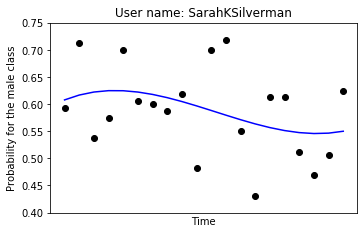

McGuinnessEU


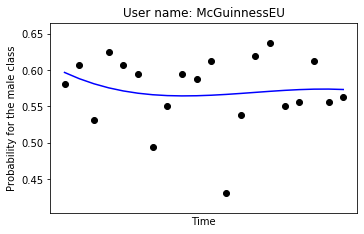

joniernst


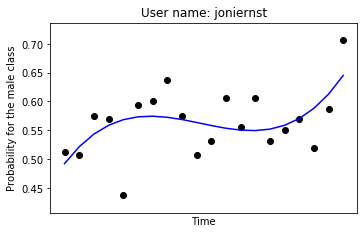

ananavarro


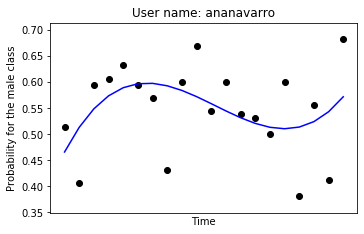

BarbMcQuade


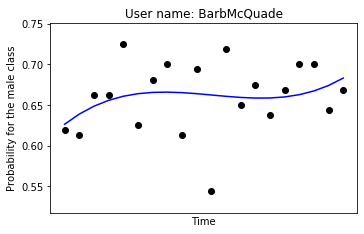

JillWineBanks


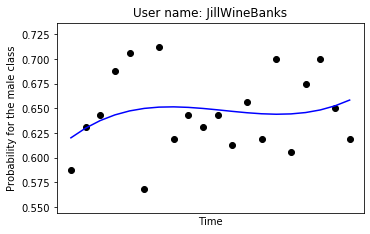

RepKatiePorter


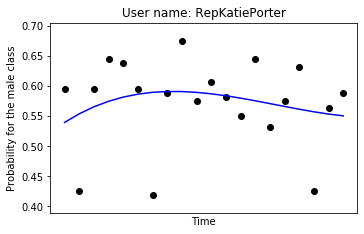

SenFeinstein


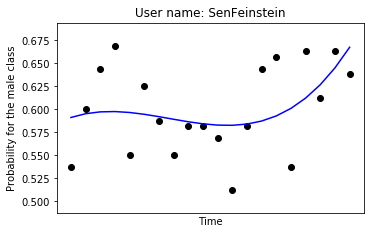

maziehirono


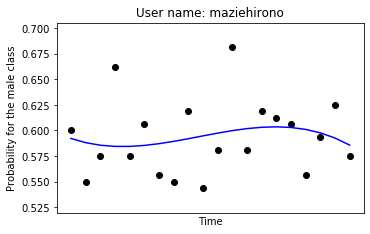

RepMaxineWaters


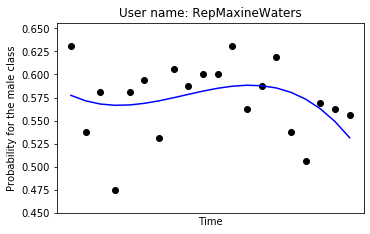

TulsiGabbard


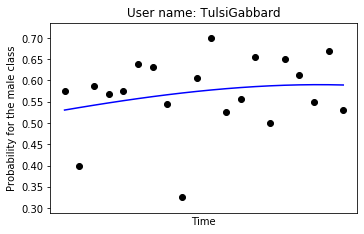

JudgeJeanine


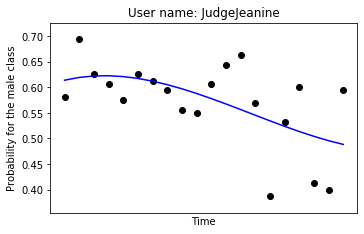

GOPChairwoman


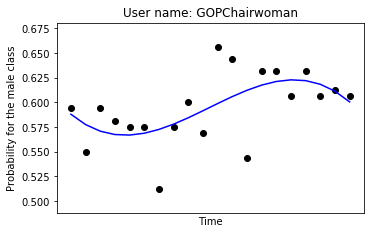

camanpour


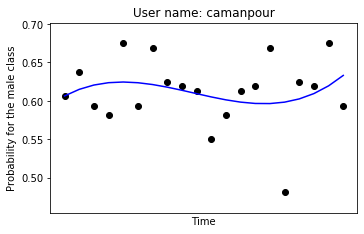

wendykopp


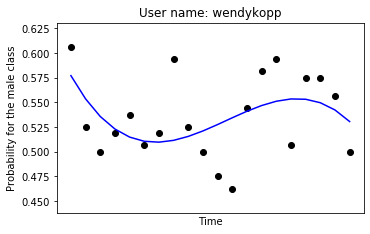

RobinRoberts


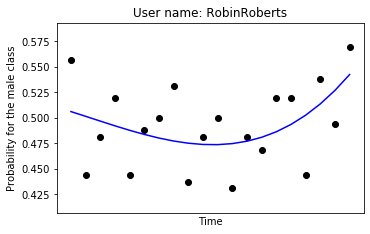

SenGillibrand


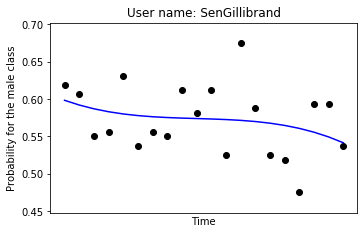

ariannahuff


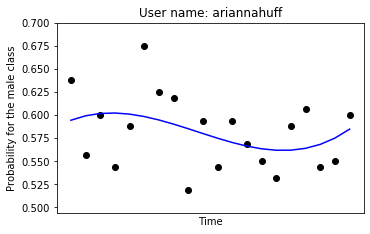

AnnCurry


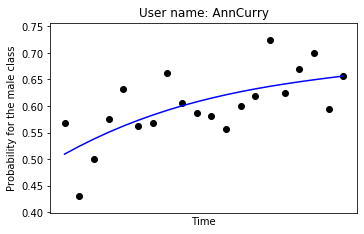

greta 


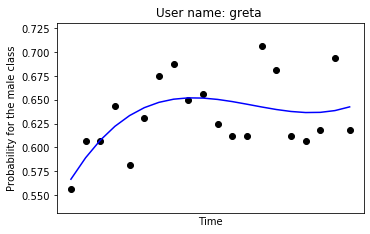

In [132]:
# plot all individual timelines
start = 0
end = 20
for user in unique_user:
    print(user)
    male_prob_list = stylometry_text['male_prob'][start:end].tolist()
    male_prob_list.reverse()
    time = list(range(0,20))
    
    
    
    fig = plt.figure(figsize=(5.5, 3.5))
    ax = fig.add_subplot(111)
    ax.scatter(time, male_prob_list, color = 'black')
    z = np.polyfit(time, male_prob_list, 3)
    p = np.poly1d(z)
    plt.plot(time, p(time), 'b')
    plt.title('User name: ' + str(user))
    plt.ylabel('Probability for the male class')
    plt.xlabel('Time')
    plt.xticks([])
    plt.show()
    
    start += 20
    end += 20

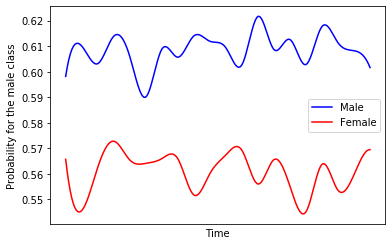

In [127]:
# plot trend per gender
sum_male = [0] * 20
sum_female = [0] * 20

start = 0
end = 20
for user in unique_user:
    if stylometry_text['Gender_binary'][start] == 0:
        male_prob_list = stylometry_text['male_prob'][start:end].tolist()
        male_prob_list.reverse()
        
        zipped_lists = zip(male_prob_list, sum_male)
        summed_lists = [x + y for (x, y) in zipped_lists]
        sum_male = summed_lists
        
    if stylometry_text['Gender_binary'][start] == 1:
        male_prob_list = stylometry_text['male_prob'][start:end].tolist()
        male_prob_list.reverse()
        
        zipped_lists = zip(male_prob_list, sum_female)
        summed_lists = [x + y for (x, y) in zipped_lists]
        sum_female = summed_lists   
        
    start += 20
    end += 20

from scipy.interpolate import make_interp_spline, BSpline
  
avg_male = np.array(sum_male) / 54
avg_female = np.array(sum_female) / 51
time = np.array(list(range(0,20)))

time_new = np.linspace(time.min(), time.max(), 200) 

spl = make_interp_spline(time, avg_male, k=3)
avg_male_smooth = spl(time_new)

spl_female = make_interp_spline(time, avg_female, k=3)
avg_female_smooth = spl_female(time_new)

plt.plot(time_new, avg_male_smooth, color = 'b', label='Male')
plt.plot(time_new, avg_female_smooth, color = 'r', label='Female')
plt.ylabel('Probability for the male class')
plt.xlabel('Time')
plt.xticks([])
plt.legend()
plt.show()

In [163]:
# plot trend per gender, per succession category
succession = pd.read_excel("succession-category.ods", engine="odf")
succession = stylometry_text. merge(succession, on='User_name', how='left')

sum_male_b = [0] * 20
sum_male_p = [0] * 20
sum_male_m = [0] * 20

nr_male_b = 0
nr_male_p = 0
nr_male_m = 0

sum_female_b = [0] * 20
sum_female_p = [0] * 20
sum_female_m = [0] * 20

nr_female_b = 0
nr_female_p = 0
nr_female_m = 0

start = 0
end = 20
for user in unique_user:
    if succession['Gender_binary'][start] == 0:
        if succession['Succession_category'][start] == 'B':
            male_prob_list_b = succession['male_prob'][start:end].tolist()
            male_prob_list_b.reverse()
        
            zipped_lists_b = zip(male_prob_list_b, sum_male_b)
            summed_lists_b = [x + y for (x, y) in zipped_lists_b]
            sum_male_b = summed_lists_b
            
            nr_male_b += 1
            
        if succession['Succession_category'][start] == 'P':
            male_prob_list_p = succession['male_prob'][start:end].tolist()
            male_prob_list_p.reverse()
        
            zipped_lists_p = zip(male_prob_list_p, sum_male_p)
            summed_lists_p = [x + y for (x, y) in zipped_lists_p]
            sum_male_p = summed_lists_p
            
            nr_male_p += 1
            
        if succession['Succession_category'][start] == 'M':
            male_prob_list_m = succession['male_prob'][start:end].tolist()
            male_prob_list_m.reverse()
        
            zipped_lists_m = zip(male_prob_list_m, sum_male_m)
            summed_lists_m = [x + y for (x, y) in zipped_lists_m]
            sum_male_m = summed_lists_m
            
            nr_male_m += 1
            
    if succession['Gender_binary'][start] == 1:
        if succession['Succession_category'][start] == 'B':
            male_prob_list_b = succession['male_prob'][start:end].tolist()
            male_prob_list_b.reverse()
        
            zipped_lists_b = zip(male_prob_list_b, sum_female_b)
            summed_lists_b = [x + y for (x, y) in zipped_lists_b]
            sum_female_b = summed_lists_b
            
            nr_female_b +=1
            
        if succession['Succession_category'][start] == 'P':
            male_prob_list_p = succession['male_prob'][start:end].tolist()
            male_prob_list_p.reverse()
        
            zipped_lists_p = zip(male_prob_list_p, sum_female_p)
            summed_lists_p = [x + y for (x, y) in zipped_lists_p]
            sum_female_p = summed_lists_p
            
            nr_female_p += 1
            
        if succession['Succession_category'][start] == 'M':
            male_prob_list_m = succession['male_prob'][start:end].tolist()
            male_prob_list_m.reverse()
        
            zipped_lists_m = zip(male_prob_list_m, sum_female_m)
            summed_lists_m = [x + y for (x, y) in zipped_lists_m]
            sum_female_m = summed_lists_m
            
            nr_female_m += 1
        
    start += 20
    end += 20

avg_male_b = np.array(sum_male_b) / nr_male_b
avg_male_p = np.array(sum_male_p) / nr_male_p
avg_male_m = np.array(sum_male_m) / nr_male_m

avg_female_b = np.array(sum_female_b) / nr_female_b
avg_female_p = np.array(sum_female_p) / nr_female_p
avg_female_m = np.array(sum_female_m) / nr_female_m

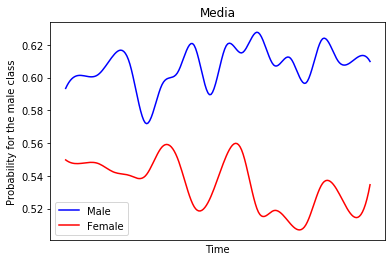

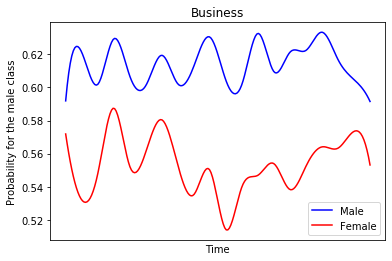

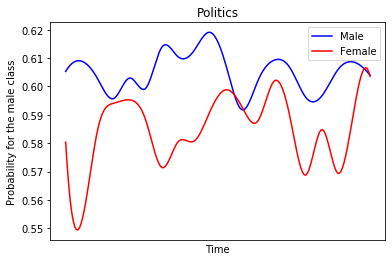

In [172]:
time = np.array(list(range(0,20)))
time_new = np.linspace(time.min(), time.max(), 200) 

spl_male_b = make_interp_spline(time, avg_male_b, k=3)
avg_male_smooth_b = spl_male_b(time_new)

spl_female_b = make_interp_spline(time, avg_female_b, k=3)
avg_female_smooth_b = spl_female_b(time_new)


spl_male_p = make_interp_spline(time, avg_male_p, k=3)
avg_male_smooth_p = spl_male_p(time_new)

spl_female_p = make_interp_spline(time, avg_female_p, k=3)
avg_female_smooth_p = spl_female_p(time_new)


spl_male_m = make_interp_spline(time, avg_male_m, k=3)
avg_male_smooth_m = spl_male_m(time_new)

spl_female_m = make_interp_spline(time, avg_female_m, k=3)
avg_female_smooth_m = spl_female_m(time_new)



plt.plot(time_new, avg_male_smooth_m, color = 'b', label='Male')
plt.plot(time_new, avg_female_smooth_m, color = 'r', label='Female')
plt.title('Media')
plt.ylabel('Probability for the male class')
plt.xlabel('Time')
plt.xticks([])
plt.legend()
plt.show()


plt.plot(time_new, avg_male_smooth_b, color = 'b', label='Male')
plt.plot(time_new, avg_female_smooth_b, color = 'r', label='Female')
plt.title('Business')
plt.ylabel('Probability for the male class')
plt.xlabel('Time')
plt.xticks([])
plt.legend()
plt.show()


plt.plot(time_new, avg_male_smooth_p, color = 'b', label='Male')
plt.plot(time_new, avg_female_smooth_p, color = 'r', label='Female')
plt.title('Politics')
plt.ylabel('Probability for the male class')
plt.xlabel('Time')
plt.xticks([])
plt.legend()
plt.show()